Mini Project on Online Course Users  Using PySpark

 DataSet: Online Courses.csv

 Source: https://www.kaggle.com/datasets/khaledatef1/online-courses

**Dataset Insights**

The dataset contains information on 8,490 online course user records across 80 courses, capturing key attributes that influence user engagement and learning outcomes: User ID, Course Name, Enrollment Month, Completion Status, Duration, and Year. The dataset is complete, clean, and consistent, making it suitable for analyzing user learning behavior, engagement trends, and completion patterns across different courses and time periods.

User Distribution

The number of users varies significantly across courses and months, reflecting differences in course popularity, enrollment periods, and user engagement levels.

Average users per record: ~84,000

Median users: ~1,158 (indicating many smaller courses and a few highly popular ones)

Maximum users: Over 9.7 million, representing major online programs or viral learning events.
Visual analysis would likely show a right-skewed distribution, where most courses have moderate enrollments, but a few flagship or trending courses attract exceptionally high participation.

Factors Affecting Course Enrollments

Several factors in the dataset correlate strongly with user engagement and course enrollment numbers:

Course Name: Popular or high-demand subjects (e.g., Data Science, Business, Technology) receive substantially higher enrollments than niche topics.

Month: Enrollment trends vary by month, with spikes during promotional periods, academic semesters, or global upskilling trends.

Course Composition and Trends

Course Diversity: 80 distinct courses allow for cross-subject comparisons and identification of top-performing learning domains.




In [2]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, avg, sum as spark_sum, round

# Initialize Spark Session
spark = SparkSession.builder.appName("OnlineCoursesAnalysis").getOrCreate()

# Load CSV
df = spark.read.csv("online_courses_uses.csv", header=True, inferSchema=True)

# Show schema
df.printSchema()

root
 |-- Course_ID: integer (nullable = true)
 |-- Course_Name: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Duration (hours): integer (nullable = true)
 |-- Enrolled_Students: integer (nullable = true)
 |-- Completion_Rate (%): double (nullable = true)
 |-- Platform: string (nullable = true)
 |-- Price ($): double (nullable = true)
 |-- Rating (out of 5): double (nullable = true)



In [4]:
df_clean = df.dropna().dropDuplicates()

# Count check
print("Cleaned count:", df_clean.count())

Cleaned count: 10000


In [5]:
df_derived = df_clean.withColumn(
    "Total_Activity", round(col("Duration (hours)") * (col("Completion_Rate (%)") / 100), 2)
).withColumn(
    "Average_Time_Spent", round(col("Duration (hours)") * (col("Completion_Rate (%)") / 100), 2)
)

df_derived.select("Course_Name", "Total_Activity", "Average_Time_Spent").show(5)

+-----------+--------------+------------------+
|Course_Name|Total_Activity|Average_Time_Spent|
+-----------+--------------+------------------+
| Course_289|         68.02|             68.02|
| Course_569|         29.88|             29.88|
|Course_1004|         40.44|             40.44|
|Course_1117|         56.82|             56.82|
|Course_1244|         38.61|             38.61|
+-----------+--------------+------------------+
only showing top 5 rows


In [6]:
df_graded = df_derived.withColumn(
    "Engagement_Grade",
    when(col("Total_Activity") >= 18, "A+")
    .when((col("Total_Activity") >= 15) & (col("Total_Activity") < 18), "A")
    .when((col("Total_Activity") >= 10) & (col("Total_Activity") < 15), "B")
    .otherwise("C")
)

In [7]:
df_skills = df_graded.withColumn(
    "Python_Skill_Level",
    when(col("Category") == "Technology", 
         when(col("Completion_Rate (%)") > 80, "Advanced")
         .when(col("Completion_Rate (%)") > 60, "Intermediate")
         .otherwise("Beginner"))
    .otherwise(None)
).withColumn(
    "Data_Analysis_Skill",
    when(col("Category") == "Data Science",
         when(col("Completion_Rate (%)") > 80, "Expert")
         .when(col("Completion_Rate (%)") > 60, "Skilled")
         .otherwise("Learner"))
    .otherwise(None)
)

In [8]:
df_final = df_skills.withColumn(
    "Performance_Level",
    when(col("Duration (hours)") > 18, "Excellent")
    .when((col("Duration (hours)") >= 15) & (col("Duration (hours)") <= 18), "Average")
    .otherwise("Poor")
)

In [9]:
avg_rating = df_final.groupBy("Category").agg(round(avg("Rating (out of 5)"), 2).alias("Avg_Rating"))
avg_rating.show()

# Total students enrolled per platform
students_per_platform = df_final.groupBy("Platform").agg(spark_sum("Enrolled_Students").alias("Total_Students"))
students_per_platform.show()

# Engagement grade distribution
grade_dist = df_final.groupBy("Engagement_Grade").count()
grade_dist.show()

+------------+----------+
|    Category|Avg_Rating|
+------------+----------+
|     Finance|      3.99|
| Programming|      3.99|
|          AI|      3.98|
|   Marketing|      4.01|
|      Design|       4.0|
|  Technology|      3.96|
|    Business|      3.99|
|Office Tools|       4.0|
|Data Science|      4.02|
+------------+----------+

+-----------------+--------------+
|         Platform|Total_Students|
+-----------------+--------------+
|            Udemy|       6538277|
|         Coursera|       6212505|
|LinkedIn Learning|       6323600|
|              edX|       6232148|
+-----------------+--------------+

+----------------+-----+
|Engagement_Grade|count|
+----------------+-----+
|               B|  713|
|               C|  495|
|               A|  448|
|              A+| 8344|
+----------------+-----+



In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas
pdf = df_final.toPandas()

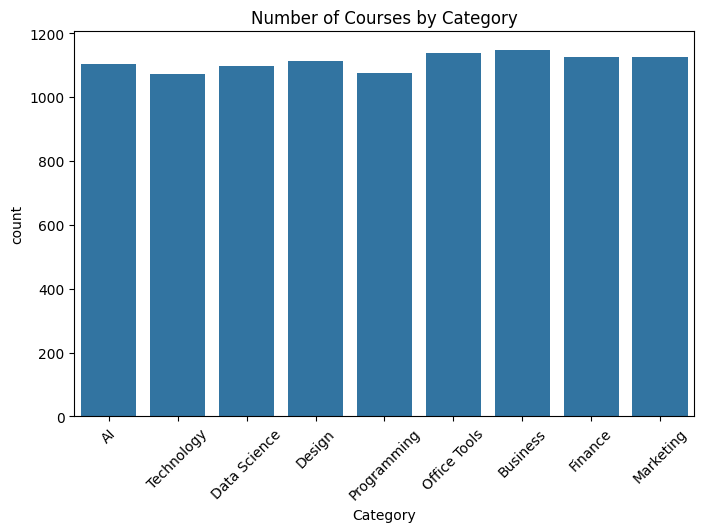

In [11]:
plt.figure(figsize=(8,5))
sns.countplot(data=pdf, x="Category")
plt.title("Number of Courses by Category")
plt.xticks(rotation=45)
plt.show()

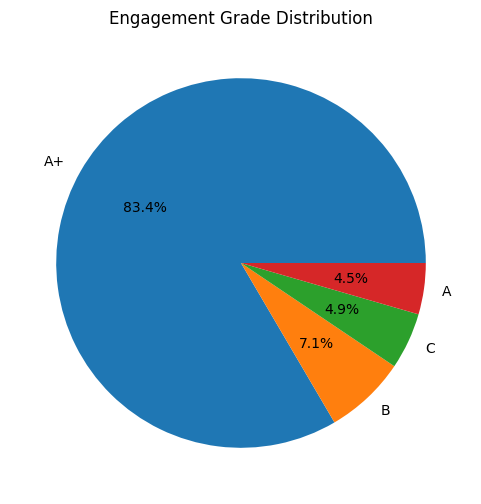

In [12]:
grade_counts = pdf["Engagement_Grade"].value_counts()
grade_counts.plot.pie(autopct="%1.1f%%", figsize=(6,6), title="Engagement Grade Distribution")
plt.ylabel("")
plt.show()

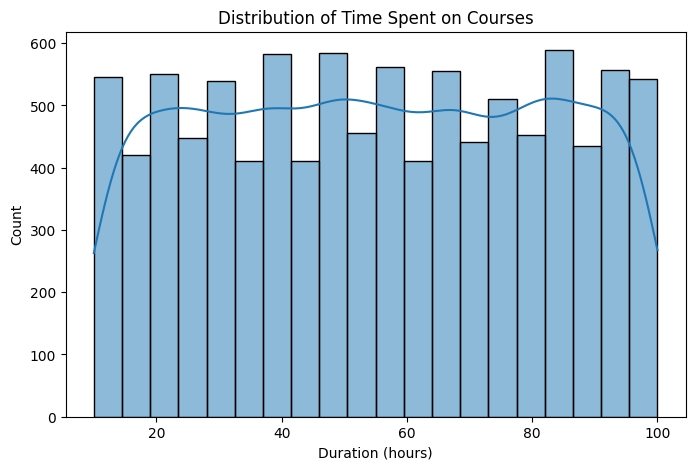

In [13]:
plt.figure(figsize=(8,5))
sns.histplot(pdf["Duration (hours)"], bins=20, kde=True)
plt.title("Distribution of Time Spent on Courses")
plt.xlabel("Duration (hours)")
plt.show()